In [3]:
!export OMP_NUM_THREADS=4

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from pathlib import Path
from scipy.interpolate import interp1d

## single model

In [5]:
workdir = Path(f'work/chaos/lorenz_nest')
if not workdir.exists():
    workdir.mkdir(parents=True)

### model


In [6]:
from model.lorenz_nest import L05nest
from model.lorenz3 import L05III

# true (Lorenz III)
nx = 960
nk = 32
ni = 12
b = 10.0
c = 0.6
h = 0.05 / b
F = 15.0
step = L05III(nx,nk,ni,b,c,h,F)
# GM (Lorenz II)
nx_gm = 240
intgm = int(nx / nx_gm)
nk_gm = nk // intgm
h_gm = 0.05 / 36
# LAM (Lorenz III)
nx_lam = 240
nk_lam = nk
ni_lam = ni
ist_lam = 520
nsp = 10
lamstep = 1
step_nest = L05nest(nx,nx_gm,nx_lam,nk_gm,nk_lam,ni_lam,b,c,h_gm,F,intgm,ist_lam,nsp,lamstep)

ni=12 alpha=0.124 beta=0.014
nx=960 nk=32
F=15.0 dt=5.000e-03
b=10.0 c=0.6
LAM
ghost point=80
ni=12 alpha=0.124 beta=0.014
nx=400 nk=32
F=15.0 dt=1.389e-03
b=10.0 c=0.6
GM
nx=240 nk=8
F=15.0 dt=1.389e-03
sponge width=10


In [7]:
phi = np.linspace(0.0,2.0*np.pi,nx+1)
x = np.cos(phi)
y = np.sin(phi)
phi_gm = np.linspace(0,2.0*np.pi,nx_gm+1)
x_gm = np.cos(phi_gm)
y_gm = np.sin(phi_gm)
phi_lam = 2.0*np.pi * step_nest.ix_lam / nx
x_lam = np.cos(phi_lam)
y_lam = np.sin(phi_lam)

### observation operator

In [8]:
from analysis.obs import Obs
obs = Obs('linear',1.0,ix=step_nest.ix_true)
obsgm = Obs('linear',1.0,ix=step_nest.ix_gm)
obslam = Obs('linear',1.0,ix=step_nest.ix_lam)

2024-02-07 19:18:18,112 anl INFO operator=linear, obserr=1.0
2024-02-07 19:18:18,113 anl INFO nvars=1
2024-02-07 19:18:18,113 anl INFO operator=linear, obserr=1.0
2024-02-07 19:18:18,113 anl INFO nvars=1
2024-02-07 19:18:18,113 anl INFO operator=linear, obserr=1.0
2024-02-07 19:18:18,114 anl INFO nvars=1


### analysis method

In [9]:
from analysis.envar import EnVAR
ne = 30
analysis_gm = EnVAR(nx_gm,ne,obsgm,linf=True,infl_parm=1.05)
analysis_lam = EnVAR(nx_lam,ne,obslam,linf=True,infl_parm=1.05)

2024-02-07 19:18:18,124 anl INFO model : model
2024-02-07 19:18:18,124 anl INFO ndim=240 nmem=30
2024-02-07 19:18:18,124 anl INFO pt=envar op=linear sig=1.0 infl_parm=1.05 lsig=-1.0
2024-02-07 19:18:18,125 anl INFO linf=True iloc=None ltlm=False incremental=True
2024-02-07 19:18:18,125 anl INFO model : model
2024-02-07 19:18:18,125 anl INFO ndim=240 nmem=30
2024-02-07 19:18:18,125 anl INFO pt=envar op=linear sig=1.0 infl_parm=1.05 lsig=-1.0
2024-02-07 19:18:18,125 anl INFO linf=True iloc=None ltlm=False incremental=True


### truth and initial ensemble

In [10]:
z0i = np.zeros(nx)
z0i[nx//2] += F*0.01
for i in range(100*int(0.05/h)):
    z0i = step(z0i)
ne = 30
t2gm = interp1d(step_nest.ix_true,z0i)
z0i_gm = t2gm(step_nest.ix_gm)
z0ei_gm = np.zeros((nx_gm,ne))
for j in range(ne):
    z0ei_gm[:,j] = z0i_gm[:]
    z0ei_gm[:,j] = z0i_gm[:] + np.random.randn(nx_gm)*0.1
gm2lam = interp1d(step_nest.ix_gm,z0ei_gm,axis=0)
z0ei_lam = gm2lam(step_nest.ix_lam)

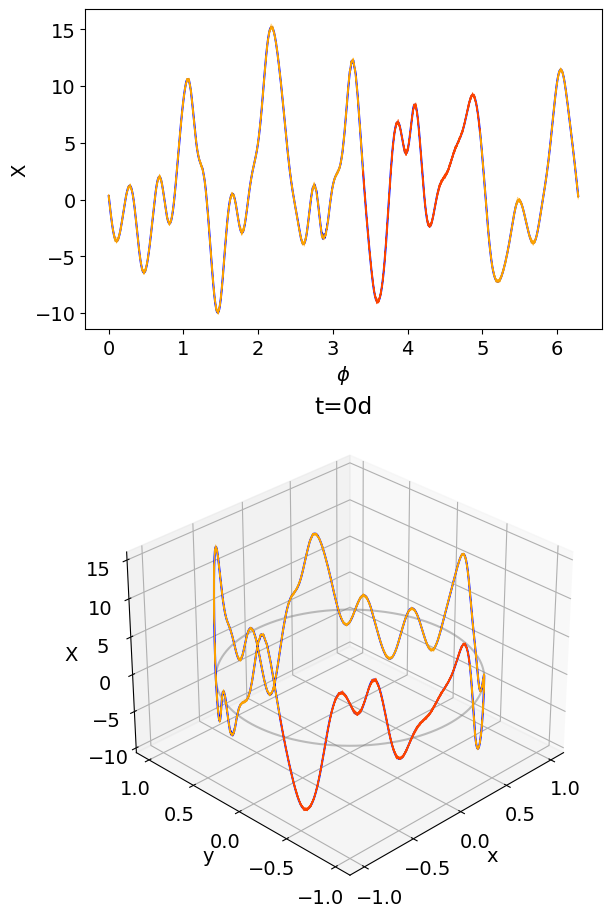

In [11]:
zb = np.hstack((z0i,[z0i[0]]))
zbe_gm = np.vstack((z0ei_gm,z0ei_gm[0].reshape(1,-1)))
zbe_lam = z0ei_lam.copy()
t=0.0
fig = plt.figure(figsize=[6,9],constrained_layout=True)
gs0 = gridspec.GridSpec(5,1,figure=fig)
ax0 = fig.add_subplot(gs0[:2,:])
ax1 = fig.add_subplot(gs0[2:,:],projection='3d')
ax0.set_xlabel(r'$\phi$')
ax0.set_ylabel('X')
ax1.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_zlabel('X')
labels = []
lines = []
ax0.plot(phi,zb,c='b',lw=1.5)
ax1.plot(x,y,zb,c='b',lw=1.5)
labels.append('truth')
lines.append(Line2D([0],[0],color='b',lw=1.5))
for i in range(zbe_gm.shape[1]):
    #c = cmap(i)
    c = 'orange'
    ax0.plot(phi_gm,zbe_gm[:,i],c=c,lw=0.5,alpha=0.5)
    ax1.plot(x_gm,y_gm,zbe_gm[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('GM ensemble')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
    c = 'r'
    ax0.plot(phi_lam,zbe_lam[:,i],c=c,lw=0.5,alpha=0.5)
    ax1.plot(x_lam,y_lam,zbe_lam[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('GM ensemble')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax1.set_title(f't={int(t/0.05/4)}d')
ax1.view_init(elev=30.,azim=225.)
plt.show()

### settings

In [32]:
nt6h = int(0.05/h)
ntmax = nt6h * 4 * 40
nstanl = nt6h * 4 * 20 # assimilation start
zt = []
ze_gm = []
za_gm = []
ze_lam = []
za_lam = []
z0 = z0i.copy()
z0e_gm = z0ei_gm.copy()
z0a_gm = z0e_gm.copy()
z0e_lam = z0ei_lam.copy()
z0a_lam = z0e_lam.copy()
zt.append(z0)
ze_gm.append(z0e_gm)
za_gm.append(z0a_gm)
ze_lam.append(z0e_lam)
za_lam.append(z0a_lam)

In [33]:
for i in range(ntmax):
    t += h
    z0 = step(z0)
    if i % nt6h == 0:
        z0e_gm, z0e_lam = step_nest(z0e_gm,z0e_lam)
        z0a_gm, z0a_lam = step_nest(z0a_gm,z0a_lam)
        if i >= nstanl:
            obsloc = np.arange(0,nx,4)
            iobs_lam = np.where((obsloc >= step_nest.ix_lam[0])&(obsloc<=step_nest.ix_lam[-1]), 1, 0)
            obsloc_lam = obsloc[iobs_lam==1.0]
            yobs = obs.add_noise(obs.h_operator(obsloc,z0))
            yobs_lam = yobs[iobs_lam==1.0]
            z0a_gm,_,_,_,_,_ = analysis_gm(z0a_gm,z0a_gm,yobs,obsloc)
            z0a_lam,_,_,_,_,_ = analysis_lam(z0a_lam,z0a_lam,yobs_lam,obsloc_lam)
        zt.append(z0)
        ze_gm.append(z0e_gm)
        za_gm.append(z0a_gm)
        ze_lam.append(z0e_lam)
        za_lam.append(z0a_lam)

2024-02-07 19:41:04,307 anl INFO save_dh=False
2024-02-07 19:41:04,311 anl INFO ==inflation==, alpha=1.05
2024-02-07 19:41:04,326 anl INFO method=CG
2024-02-07 19:41:04,333 anl INFO cgtype: Fletcher-Reeves
2024-02-07 19:41:04,334 anl INFO restart=False
2024-02-07 19:41:04,335 anl INFO save_hist=False
2024-02-07 19:41:04,336 anl INFO jb:0.000000e+00 jo:4.791523e+03
2024-02-07 19:41:04,337 anl INFO |dj|:7.775588e+01
2024-02-07 19:41:04,338 anl INFO jb:2.094918e-02 jo:4.713480e+03
2024-02-07 19:41:04,339 anl INFO |dj|:7.674390e+01
2024-02-07 19:41:04,340 anl INFO jb:5.237296e-01 jo:4.411109e+03
2024-02-07 19:41:04,340 anl INFO |dj|:7.269600e+01
2024-02-07 19:41:04,341 anl INFO jb:9.238590e+00 jo:3.358455e+03
2024-02-07 19:41:04,343 anl INFO |dj|:5.650442e+01
2024-02-07 19:41:04,350 anl INFO jb:1.236783e+02 jo:1.650758e+03
2024-02-07 19:41:04,357 anl INFO |dj|:2.159970e-01
2024-02-07 19:41:04,365 anl INFO jb:1.227040e+02 jo:1.651709e+03
2024-02-07 19:41:04,367 anl INFO |dj|:1.753796e-03
20

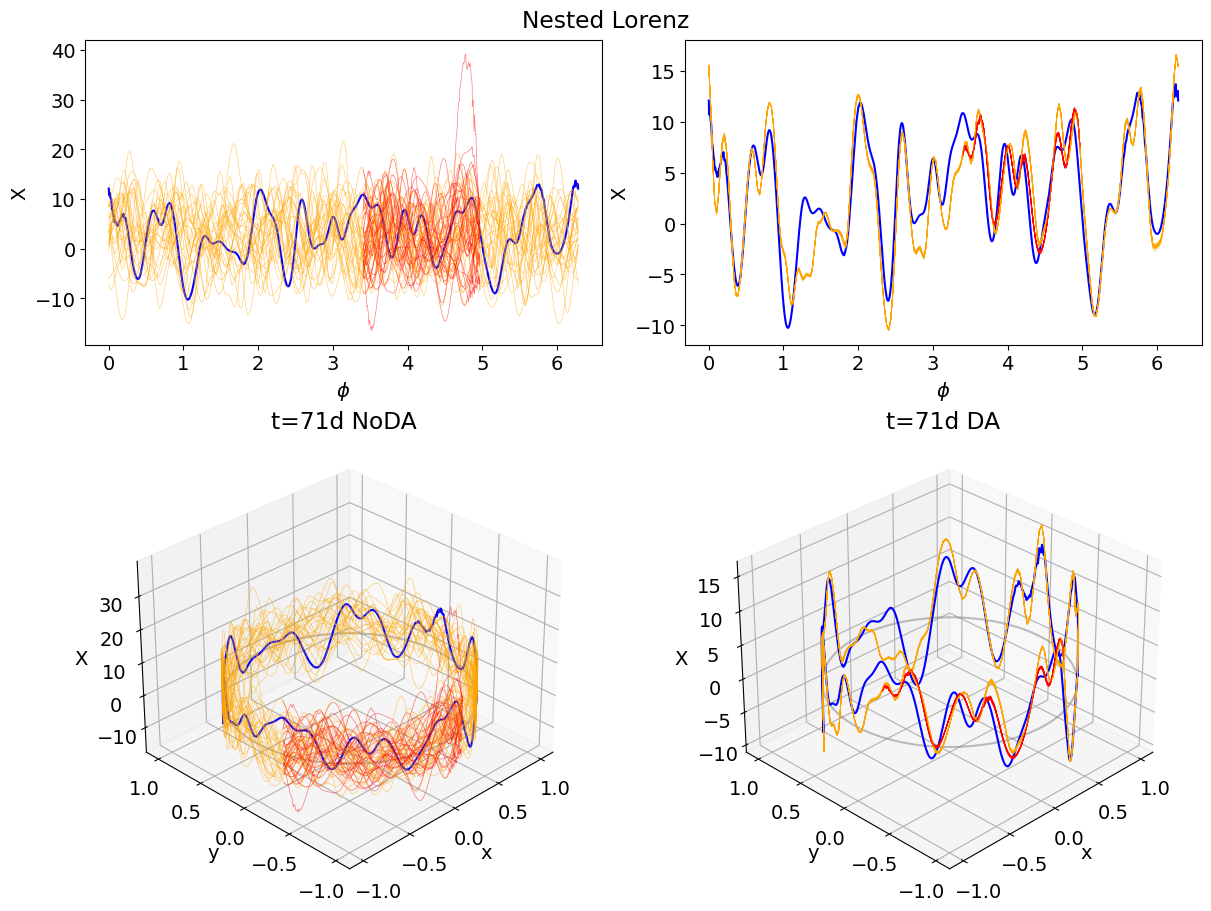

In [34]:
zb = np.hstack((z0,[z0[0]]))
zbe_gm = np.vstack((z0e_gm,z0e_gm[0].reshape(1,-1)))
zba_gm = np.vstack((z0a_gm,z0a_gm[0].reshape(1,-1)))
zbe_lam = z0e_lam.copy()
zba_lam = z0a_lam.copy()
fig = plt.figure(figsize=[12,9],constrained_layout=True)
gs = gridspec.GridSpec(1,2,figure=fig)
gs0 = gs[0].subgridspec(5,1)
ax0 = fig.add_subplot(gs0[:2,:])
ax1 = fig.add_subplot(gs0[2:,:],projection='3d')
ax0.set_xlabel(r'$\phi$')
ax0.set_ylabel('X')
ax1.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_zlabel('X')
gs1 = gs[1].subgridspec(5,1)
ax2 = fig.add_subplot(gs1[:2,:])
ax3 = fig.add_subplot(gs1[2:,:],projection='3d')
ax2.set_xlabel(r'$\phi$')
ax2.set_ylabel('X')
ax3.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
#ax3.set_xticklabels([])
#ax3.set_yticklabels([])
ax3.set_zlabel('X')
labels = []
lines = []
ax0.plot(phi,zb,c='b',lw=1.5)
ax1.plot(x,y,zb,c='b',lw=1.5)
ax2.plot(phi,zb,c='b',lw=1.5)
ax3.plot(x,y,zb,c='b',lw=1.5)
labels.append('truth')
lines.append(Line2D([0],[0],color='b',lw=1.5))
for i in range(zbe_gm.shape[1]):
    #c = cmap(i)
    c = 'orange'
    ax0.plot(phi_gm,zbe_gm[:,i],c=c,lw=0.5,alpha=0.5)
    ax1.plot(x_gm,y_gm,zbe_gm[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('GM ensemble')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
    c = 'r'
    ax0.plot(phi_lam,zbe_lam[:,i],c=c,lw=0.5,alpha=0.5)
    ax1.plot(x_lam,y_lam,zbe_lam[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('LAM ensemble')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax1.set_title(f't={int(t/0.05/4)}d NoDA')
ax1.view_init(elev=30.,azim=225.)
for i in range(zba_gm.shape[1]):
    #c = cmap(i)
    c = 'orange'
    ax2.plot(phi_gm,zba_gm[:,i],c=c,lw=0.5,alpha=0.5)
    ax3.plot(x_gm,y_gm,zba_gm[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('GM ensemble')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
    c = 'r'
    ax2.plot(phi_lam,zba_lam[:,i],c=c,lw=0.5,alpha=0.5)
    ax3.plot(x_lam,y_lam,zba_lam[:,i],c=c,lw=0.5,alpha=0.5)
    if i==0:
        labels.append('LAM ensemble')
        lines.append(Line2D([0],[0],color=c,lw=0.5,alpha=0.5))
ax3.set_title(f't={int(t/0.05/4)}d DA')
ax3.view_init(elev=30.,azim=225.)
fig.suptitle('Nested Lorenz')
fig.savefig(workdir/'chaos_da.png',dpi=300)
plt.show()

it=0 icycle=-79


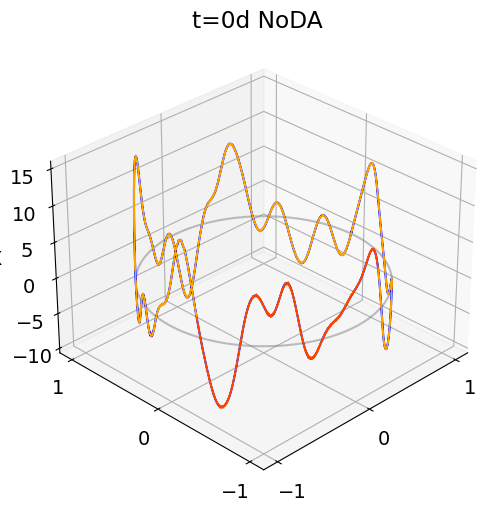

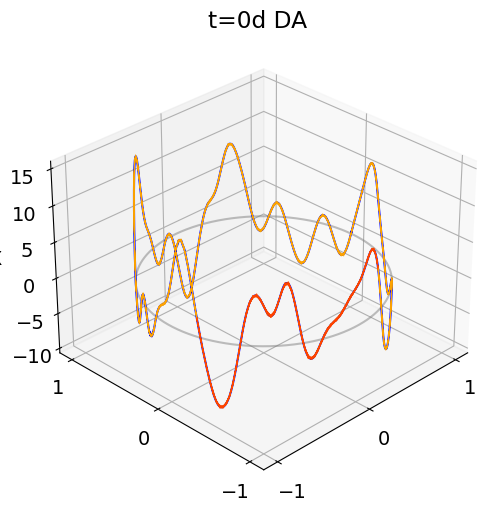

it=20 icycle=-59


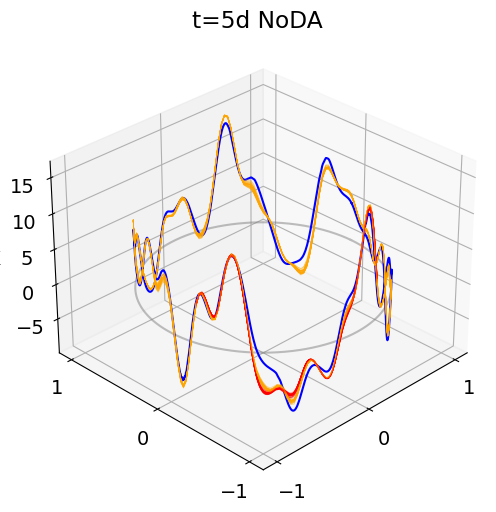

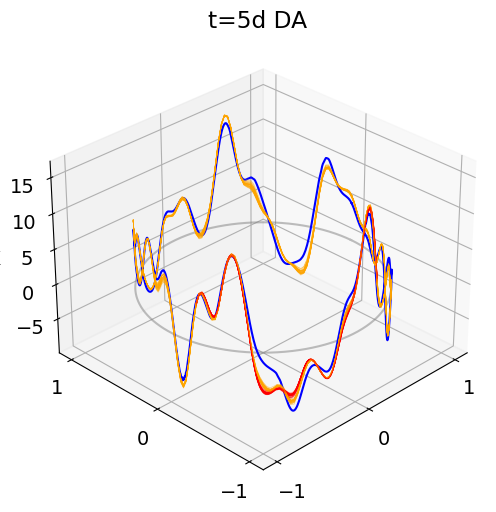

it=40 icycle=-39


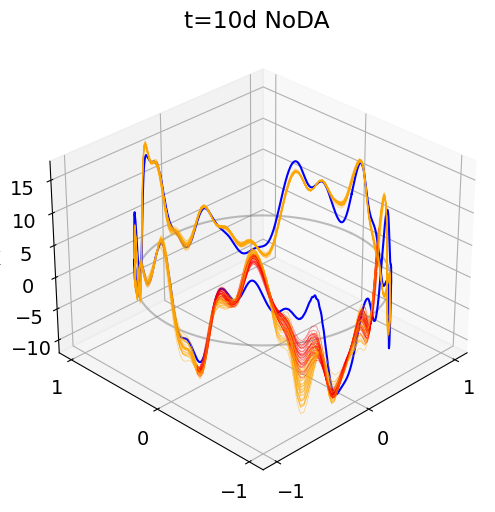

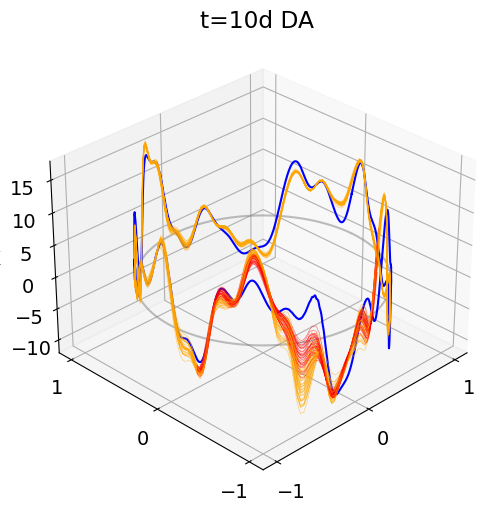

it=60 icycle=-19


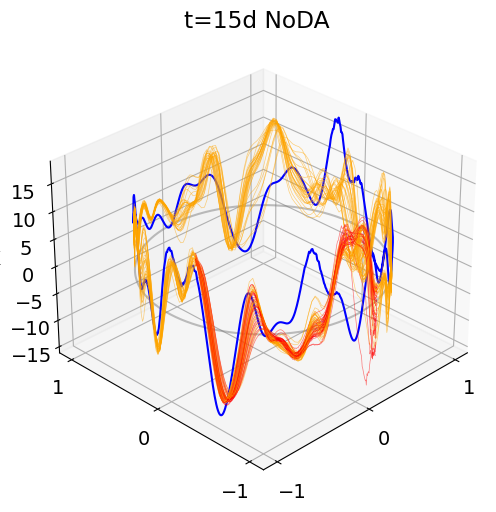

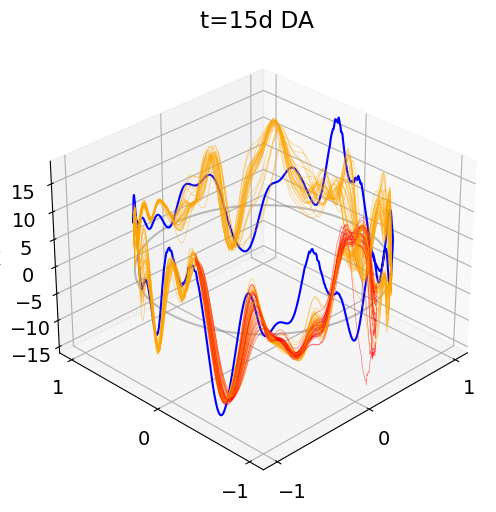

it=80 icycle=1


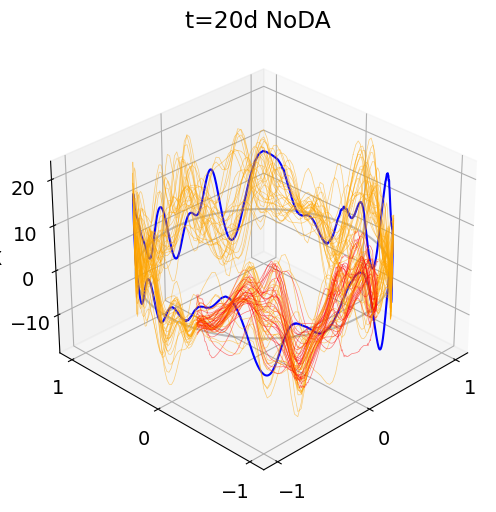

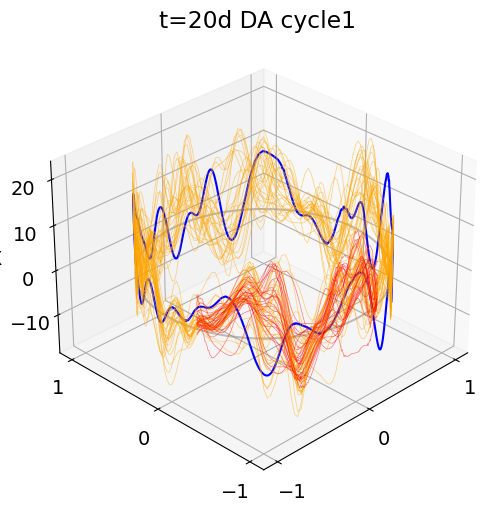

it=100 icycle=21


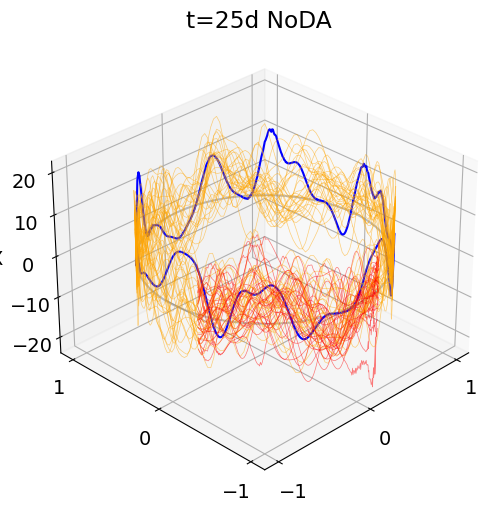

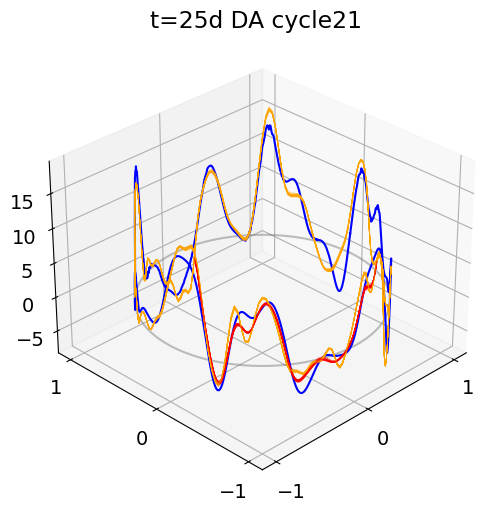

it=120 icycle=41


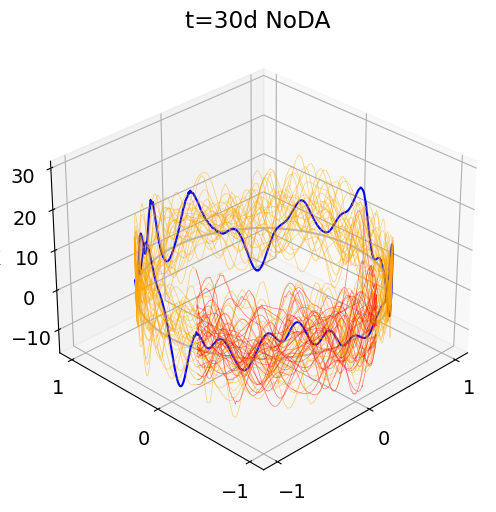

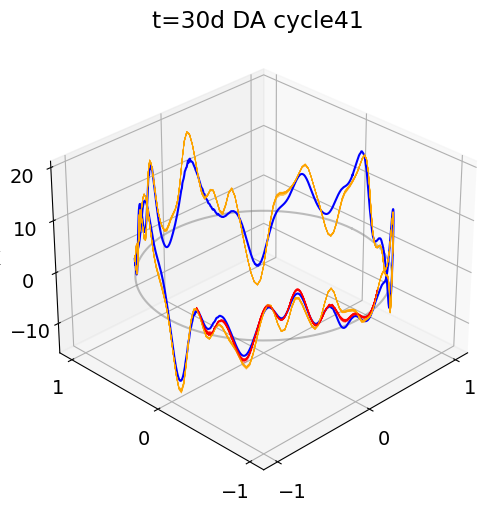

In [40]:
dindex = np.arange(0,35,5)
for day in dindex:
    it = day * 4
    icycle = (it - (nstanl//nt6h)) + 1
    print(f"it={it} icycle={icycle}")
    zt1 = zt[it]
    ze1_gm = ze_gm[it]
    za1_gm = za_gm[it]
    ze1_lam = ze_lam[it]
    za1_lam = za_lam[it]
    zb = np.hstack((zt1,[zt1[0]]))
    zbe_gm = np.vstack((ze1_gm,ze1_gm[0].reshape(1,-1)))
    zba_gm = np.vstack((za1_gm,za1_gm[0].reshape(1,-1)))
    zbe_lam = ze1_lam.copy()
    zba_lam = za1_lam.copy()
    fig = plt.figure(figsize=[6,5],constrained_layout=True)
    ax = fig.add_subplot(111,projection='3d')
    ax.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
    #ax.set_xlabel('x')
    #ax.set_ylabel('y')
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zlabel('X')
    ax.plot(x,y,zb,c='b',lw=1.5)
    for i in range(zbe_gm.shape[1]):
        #c = cmap(i)
        c = 'orange'
        ax.plot(x_gm,y_gm,zbe_gm[:,i],c=c,lw=0.5,alpha=0.5)
        c = 'r'
        ax.plot(x_lam,y_lam,zbe_lam[:,i],c=c,lw=0.5,alpha=0.5)
    ax.set_title(f't={day}d NoDA')
    ax.view_init(elev=30.,azim=225.)
    fig.savefig(workdir/f'chaos_noda_d{day}.png',dpi=300)
    plt.show()
    plt.close()
    fig = plt.figure(figsize=[6,5],constrained_layout=True)
    ax = fig.add_subplot(111,projection='3d')
    ax.plot(x,y,np.zeros_like(x),c='gray',alpha=0.5)
    #ax.set_xlabel('x')
    #ax.set_ylabel('y')
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zlabel('X')
    ax.plot(x,y,zb,c='b',lw=1.5)
    for i in range(zba_gm.shape[1]):
        #c = cmap(i)
        c = 'orange'
        ax.plot(x_gm,y_gm,zba_gm[:,i],c=c,lw=0.5,alpha=0.5)
        c = 'r'
        ax.plot(x_lam,y_lam,zba_lam[:,i],c=c,lw=0.5,alpha=0.5)
    if icycle > 0:
        ax.set_title(f't={day}d DA cycle{icycle}')
    else:
        ax.set_title(f't={day}d DA')
    ax.view_init(elev=30.,azim=225.)
    fig.savefig(workdir/f'chaos_da_d{day}.png',dpi=300)
    plt.show()
    plt.close()

### animation

2024-02-07 19:27:13,285 matplotlib.animation INFO Animation.save using <class 'matplotlib.animation.PillowWriter'>


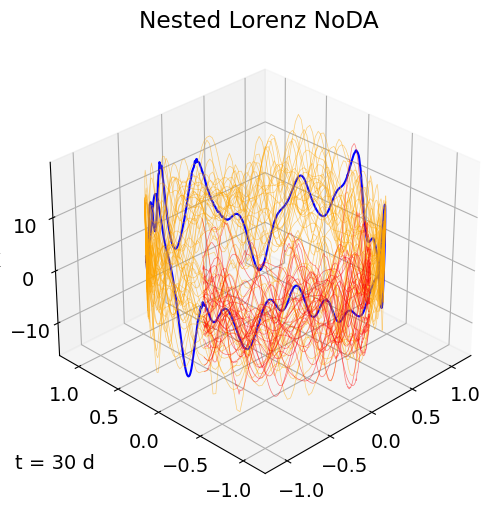

In [19]:
import matplotlib.animation as animation

zmin = np.min(np.array(zt))
zmax = np.max(np.array(zt))
fig= plt.figure(figsize=[6,6])
ax = fig.add_subplot(projection='3d',\
    autoscale_on=False,xlim=(-1.2,1.2),ylim=(-1.2,1.2),zlim=(zmin-0.1,zmax+0.1))
ax.set_zlabel('X')
ax.set_title(f'Nested Lorenz NoDA')
ax.view_init(elev=30.,azim=225.)
lines = []
truth, = ax.plot([],[],[],c='b',lw=1.5)
lines.append(truth)
for j in range(1,ne+1):
    ensfcst_gm, = ax.plot([],[],[],c='orange',lw=0.5,alpha=0.5)
    lines.append(ensfcst_gm)
for j in range(1,ne+1):
    ensfcst_lam, = ax.plot([],[],[],c='r',lw=0.5,alpha=0.5)
    lines.append(ensfcst_lam)
time_template = 't = %d d'
time_text = ax.text(0.05,0.9,20.0,'',\
    va='bottom',ha='left',transform=ax.transAxes)

def animate(i, zt, ze_gm, ze_lam, lines):
    t=int(i*nt6h*h/0.05/4)
    zt0 = zt[i]
    ze0_gm = ze_gm[i]
    ze0_lam = ze_lam[i]
    zb = np.hstack((zt0,[zt0[0]]))
    zb_gm = np.vstack((ze0_gm,ze0_gm[0,:].reshape(1,-1)))
    zb_lam = ze0_lam.copy()
    for j, line in enumerate(lines):
        if j==0:
            line.set_data(x,y)
            line.set_3d_properties(zb)
        elif j<ne+1:
            line.set_data(x_gm,y_gm)
            line.set_3d_properties(zb_gm[:,j-1])
        else:
            line.set_data(x_lam,y_lam)
            line.set_3d_properties(zb_lam[:,j-(ne+1)])
    time_text.set_text(time_template % t)
    outlist = lines + [time_text]
    return outlist

ani = animation.FuncAnimation(fig, animate, len(zt),\
    fargs=(zt,ze_gm,ze_lam,lines), interval=50)
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save(workdir/'chaos_noda.gif', writer=writer)

plt.show()

2024-02-07 19:27:22,893 matplotlib.animation INFO Animation.save using <class 'matplotlib.animation.PillowWriter'>


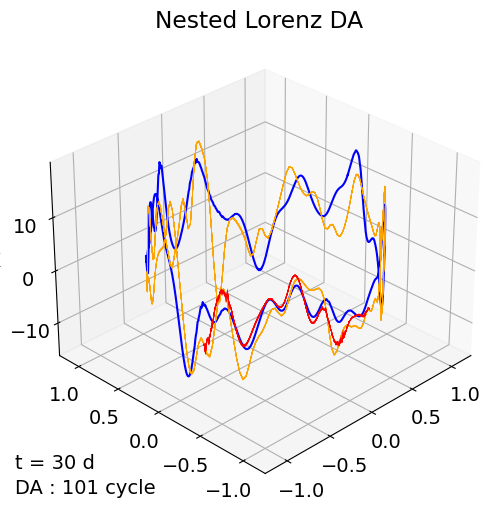

In [20]:
zmin = np.min(np.array(zt))
zmax = np.max(np.array(zt))
fig= plt.figure(figsize=[6,6])
ax = fig.add_subplot(projection='3d',\
    autoscale_on=False,xlim=(-1.2,1.2),ylim=(-1.2,1.2),zlim=(zmin-0.1,zmax+0.1))
ax.set_zlabel('X')
ax.set_title(f'Nested Lorenz DA')
ax.view_init(elev=30.,azim=225.)
lines = []
truth, = ax.plot([],[],[],c='b',lw=1.5)
lines.append(truth)
for j in range(1,ne+1):
    ensfcst_gm, = ax.plot([],[],[],c='orange',lw=0.5,alpha=0.5)
    lines.append(ensfcst_gm)
for j in range(1,ne+1):
    ensfcst_lam, = ax.plot([],[],[],c='r',lw=0.5,alpha=0.5)
    lines.append(ensfcst_lam)
time_template = 't = %d d'
time_text = ax.text(0.05,0.9,20.0,'',\
    va='bottom',ha='left',transform=ax.transAxes)
cycle_template = 'DA : %d cycle'
cycle_text = ax.text(0.05,0.9,-5.0,'',\
    va='bottom',ha='left',transform=ax.transAxes)

def animate(i, zt, za_gm, za_lam, lines):
    t=int(i*nt6h*h/0.05/4)
    zt0 = zt[i]
    ze0_gm = za_gm[i]
    ze0_lam = za_lam[i]
    zb = np.hstack((zt0,[zt0[0]]))
    zb_gm = np.vstack((ze0_gm,ze0_gm[0,:].reshape(1,-1)))
    zb_lam = ze0_lam.copy()
    for j, line in enumerate(lines):
        if j==0:
            line.set_data(x,y)
            line.set_3d_properties(zb)
        elif j<ne+1:
            line.set_data(x_gm,y_gm)
            line.set_3d_properties(zb_gm[:,j-1])
        else:
            line.set_data(x_lam,y_lam)
            line.set_3d_properties(zb_lam[:,j-(ne+1)])
    time_text.set_text(time_template % t)
    outlist = lines + [time_text]
    if i*nt6h >= nstanl: # and i%4==0:
        icycle = (i - nstanl//nt6h) + 1
        cycle_text.set_text(cycle_template % icycle)
        outlist = outlist + [cycle_text]
    return outlist

ani = animation.FuncAnimation(fig, animate, len(zt),\
    fargs=(zt,za_gm,za_lam,lines), interval=50)
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
ani.save(workdir/'chaos_da.gif', writer=writer)

plt.show()